In [70]:
import pickle
import victim_circuits.constants as v_const
from helper import circuit_runtime_in_ms

from qiskit import QuantumCircuit
from qiskit_ibm_provider import IBMProvider
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram, timeline_drawer
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling, AlignMeasures, ASAPScheduleAnalysis, PadDelay
from qiskit.transpiler import InstructionDurations
from qiskit.circuit.library import XGate

import numpy as np
import matplotlib.pyplot as plt
from bisect import bisect
import math

# Parameters

In [2]:
snooper_qubits = (1, 4, 6)
victim_qubits = (3, 5)
ibm_backend_name = 'ibm_nairobi'

In [3]:
provider = IBMProvider()
backend = provider.get_backend(ibm_backend_name)

# Create Circuits

In [4]:
def init_snoopers(qc: QuantumCircuit, snooper_qubits):
    '''
        qc: QuantumCircuit to be modified
        snooper_qubits: tuple of qubits which are the snoopers
    '''
    qc.h(snooper_qubits)
    qc.barrier()

def readout_snoopers(qc: QuantumCircuit, snooper_qubits):
    '''
        qc: QuantumCircuit to be modified
        snooper_qubits: tuple of qubits which are the snoopers
    '''
    qc.barrier()
    qc.h(snooper_qubits)
    qc.measure(snooper_qubits, range(len(snooper_qubits)))

In [57]:
backend.properties().gate_length('x', 0)/backend.configuration().dt

160.0

In [98]:
def crude_dd(qc: QuantumCircuit, snooper_qubits, victim_qc, backend):
    victim_qc_time = circuit_runtime_in_ms(victim_qc, backend)/1000
    gate_duration = backend.properties().gate_length('x', 0)
    dt_duration = backend.configuration().dt
    periods = math.ceil(victim_qc_time/(4*gate_duration))
    for i in range(periods):
        if i%4 ==0:
            qc.x(snooper_qubits)
        else:
            # qc.id(snooper_qubits)
            qc.delay(160)

In [99]:
victim_qcs = pickle.load( open( "victim_circuits/two_way_cnot_0-9.p", "rb" ) )

In [ ]:
qcs: list[QuantumCircuit] = []
for victim_qc in victim_qcs:
    qc = QuantumCircuit(backend.num_qubits, len(snooper_qubits))
    init_snoopers(qc, snooper_qubits)
    crude_dd(qc, snooper_qubits, victim_qc, backend)
    qc.append(victim_qc, victim_qubits)
    readout_snoopers(qc, snooper_qubits)
    qcs.append(qc)

In [ ]:
# n = 8
# dd_sequence = [XGate()] * n
# def uhrig_pulse_location(k):
#     return np.sin(np.pi * (k + 1) / (2 * n + 2)) ** 2
# spacing = []
# for k in range(n):
#     spacing.append(uhrig_pulse_location(k) - sum(spacing))
# spacing.append(1 - sum(spacing))

In [100]:
pm = generate_preset_pass_manager(0, backend)
durations = InstructionDurations.from_backend(backend)

pm.scheduling.append([
    ALAPScheduleAnalysis(durations),
    PadDelay()
])

In [115]:
qc = QuantumCircuit(backend.num_qubits, len(snooper_qubits))
init_snoopers(qc, snooper_qubits)
crude_dd(qc, snooper_qubits, victim_qcs[100], backend)
qc.append(victim_qc, victim_qubits)
readout_snoopers(qc, snooper_qubits)

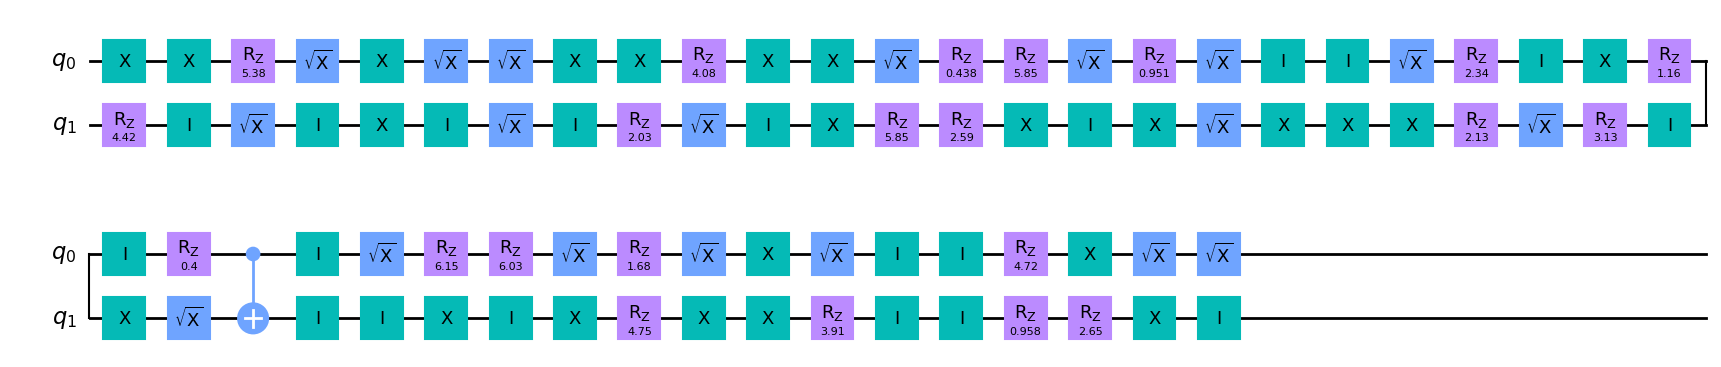

In [116]:
victim_qcs[100].draw('mpl')

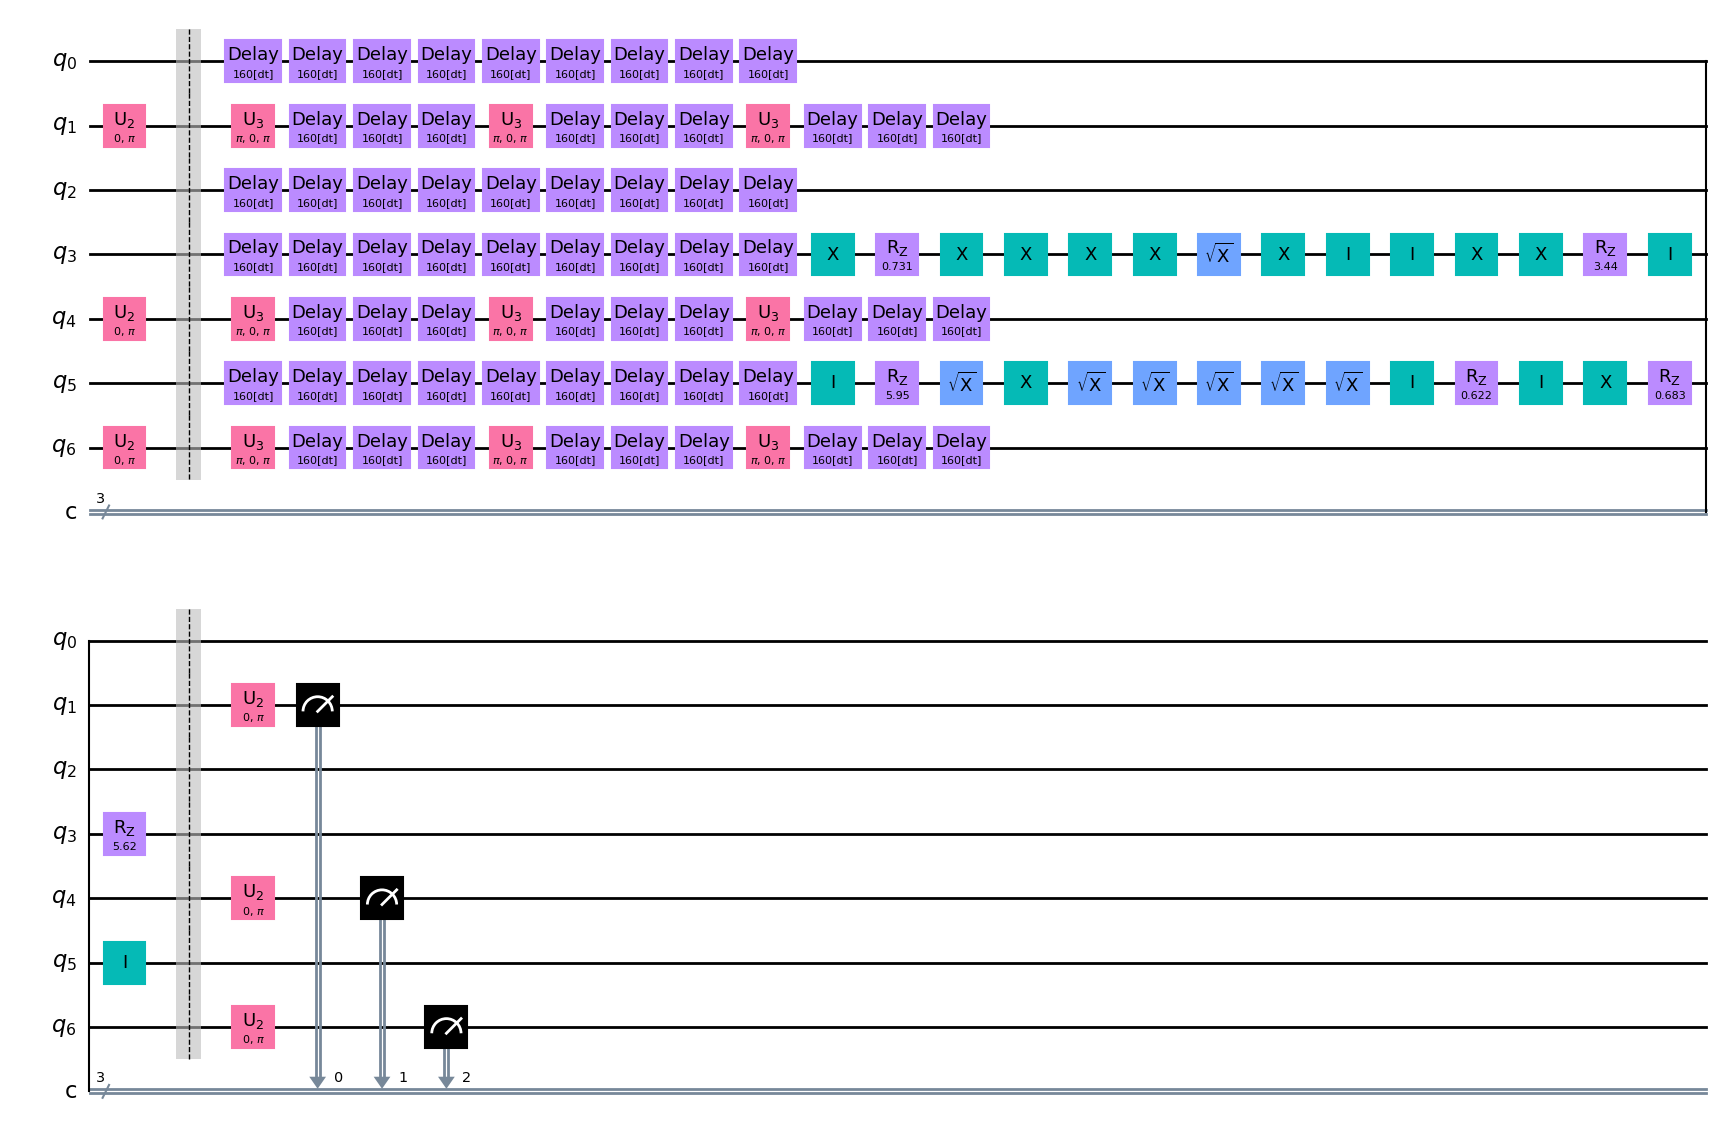

In [118]:
qc.decompose().draw('mpl')

In [112]:
tqc = pm.run(qc)


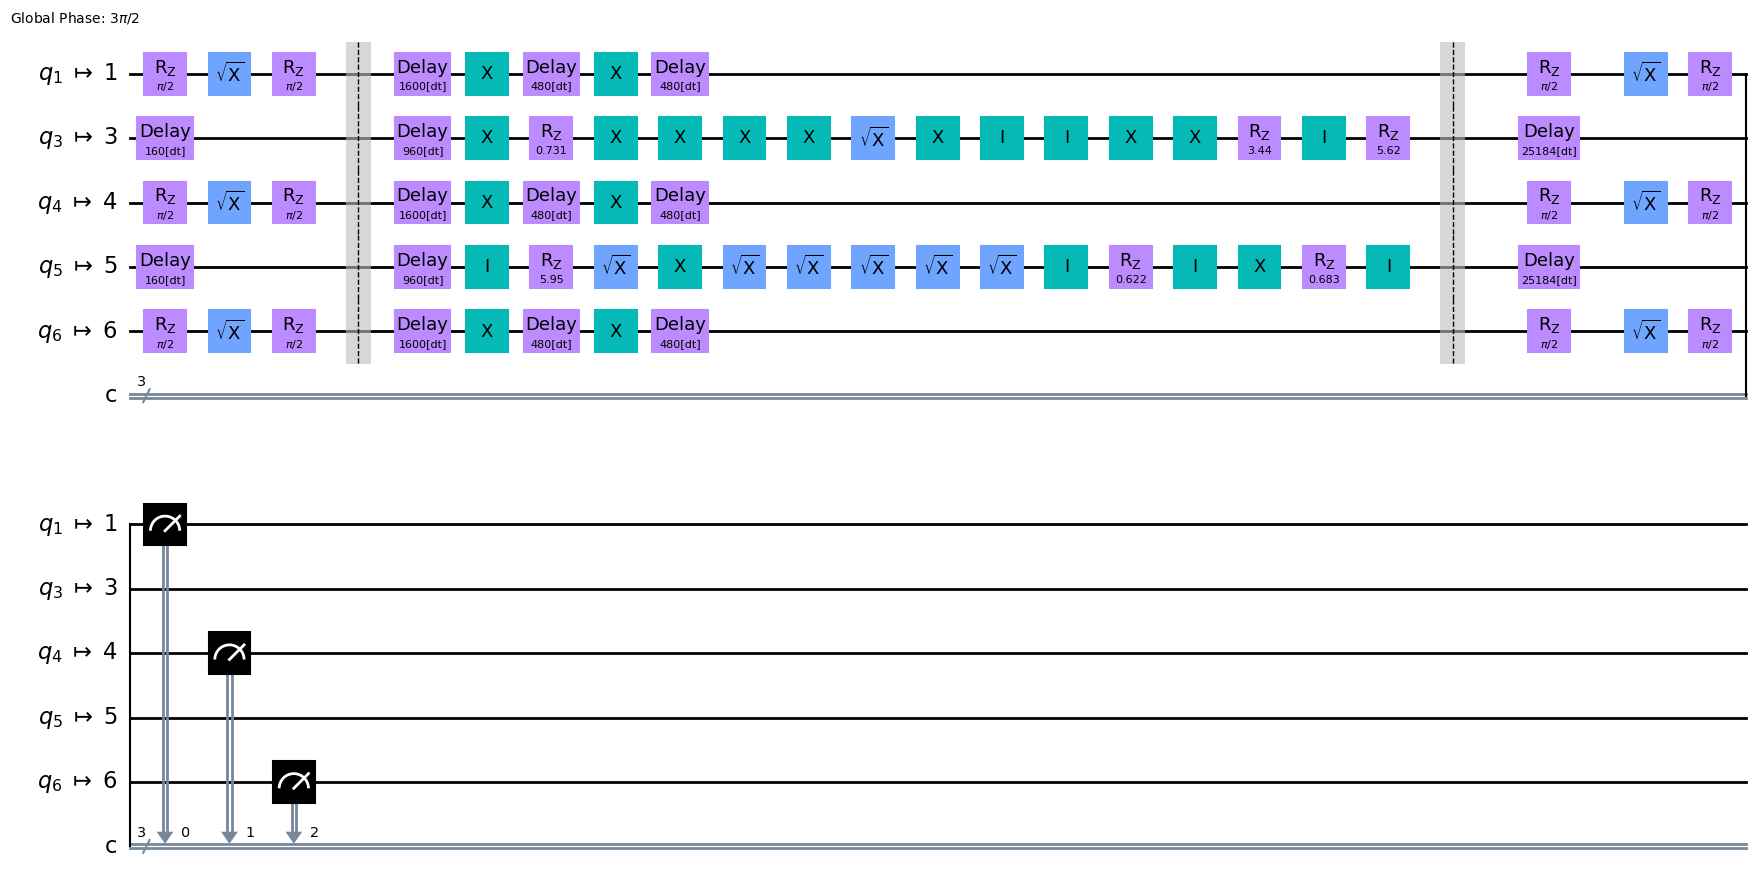

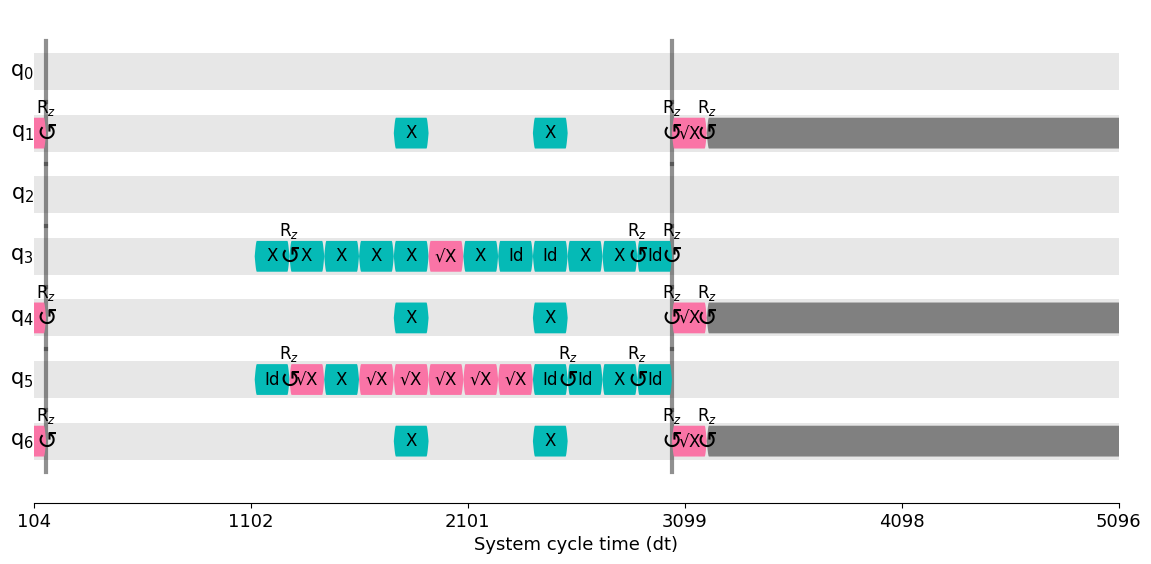

In [113]:
display(tqc.draw('mpl', idle_wires=False))
display(timeline_drawer(tqc, time_range=(200, 5000)))

In [ ]:
tqcs = pm.run(qcs)

In [ ]:
job = backend.run(tqcs, shots=8000)
job.update_tags(['snooping', 'two_way_cnot_with_dd'])
print('New job: ', job.job_id())

In [ ]:
# timeline_drawer(tqcs[500])
timeline_drawer(tqcs[500], time_range=(1000, 10000), show_idle=False)

# Checkpoint

In [ ]:
job_id = 'cgtm4ejagcl9lnhmokqg'
job = provider.backend.retrieve_job(job_id)

## Analyse Results

In [ ]:
tqcs = job.circuits()
qc_res_counts = job.result().get_counts()

In [ ]:
import os
results_path = 'results/{}/{}'.format(job.backend().name, job.job_id())
if not os.path.exists(results_path):
   os.makedirs(results_path)

In [ ]:
path = '{}/histograms'.format(results_path)
if not os.path.exists(path):
    os.makedirs(path)
    for cnot_count in cnot_vals:
        start_index = cnot_count*no_of_circuits_per_cnot_val
        data = qc_res_counts[start_index: start_index+no_of_circuits_per_cnot_val]
        title='CNOTs-{}'.format(cnot_count)
        fig, axs = plt.subplots()
        plot_histogram(data, ax=axs, title=title)
        fig.savefig('{}/{}.png'.format(path, title))
        plt.close(fig)

In [ ]:
depths_per_cnots = []
for cnot_count in cnot_vals:
    start_index = cnot_count*no_of_circuits_per_cnot_val
    depths = []
    for i in range(start_index, start_index+no_of_circuits_per_cnot_val):
        depths.append(tqcs[i].depth())
    depths_per_cnots.append(depths)

fig, axs = plt.subplots(figsize=(6, 6))
title = 'Circuit depth vs CNOTs'
axs.set_title(title)
axs.set_ylabel('Circuit depth')
axs.set_xlabel('# of CNOTs')
axs.boxplot(depths_per_cnots, labels=cnot_vals)
plt.show(fig)

fname = '{}/{}.png'.format(results_path, title)

if not os.path.isfile(fname):
    fig.savefig(fname)

In [ ]:
zero_counts_per_cnots = []
for cnot_count in cnot_vals:
    start_index = cnot_count*no_of_circuits_per_cnot_val
    zero_counts = []
    for i in range(start_index, start_index+no_of_circuits_per_cnot_val):
        zero_counts.append(qc_res_counts[i]['000'])
    zero_counts_per_cnots.append(zero_counts)

fig, axs = plt.subplots(figsize=(6, 6))
title = '000 count vs CNOTs'
axs.set_title(title)
axs.set_ylabel('# of 000')
axs.set_xlabel('# of CNOTs')
axs.boxplot(zero_counts_per_cnots, labels=cnot_vals)
plt.show(fig)

fname = '{}/{}.png'.format(results_path, title)

if not os.path.isfile(fname):
    fig.savefig(fname)

## Analyse Results with binning

In [ ]:
circuit_run_times_in_ms = []
for cnot_count in cnot_vals:
    start_index = cnot_count*no_of_circuits_per_cnot_val
    for i in range(start_index, start_index+no_of_circuits_per_cnot_val):
        circuit_run_times_in_ms.append(circuit_runtime_in_ms(tqcs[i], backend))

In [ ]:
runtimes_per_cnots = []
for cnot_count in cnot_vals:
    start_index = cnot_count*no_of_circuits_per_cnot_val
    runtimes_per_cnots.append(circuit_run_times_in_ms[start_index: start_index+no_of_circuits_per_cnot_val])

fig, axs = plt.subplots(figsize=(6, 6))
title = 'Runtimes vs CNOTs'
axs.set_title(title)
axs.set_ylabel('Runtimes in ms')
axs.set_xlabel('# of CNOTs')
axs.boxplot(runtimes_per_cnots, labels=cnot_vals)
plt.show(fig)

fname = '{}/{}.png'.format(results_path, title)

if not os.path.isfile(fname):
    fig.savefig(fname)

In [ ]:
thresholds = [0.002, 0.004, float('inf')]
batches = []
for t in thresholds:
    batches.append(set())

In [ ]:
for i, time in enumerate(circuit_run_times_in_ms):
    x = bisect(thresholds, time)
    batches[x].add(i)

In [ ]:
for b in batches:
    print(len(b))

In [ ]:
for j, b in enumerate(batches):
    dataa = []
    for cnot_count in cnot_vals:
        start_index = cnot_count*no_of_circuits_per_cnot_val
        data = []
        for i in range(start_index, start_index+no_of_circuits_per_cnot_val):
            if i in batches[j]:
                data.append(qc_res_counts[i]['000'])
        dataa.append(data)

    fig, axs = plt.subplots(figsize=(6, 6))
    title = '000 distribution - {} ms to {} ms'.format(thresholds[j-1] if j!=0 else 0, thresholds[j])
    axs.set_title(title)
    axs.boxplot(dataa, labels=cnot_vals)

    

    plt.show(fig)
    
    fname = '{}/{}.png'.format(results_path, title)

    if not os.path.isfile(fname):
        fig.savefig(fname)
    

# Splitting results

In [ ]:
split_res_counts = [[] for _ in range(3)]

for res_count in qc_res_counts:
    counts = [{'0': 0, '1': 0} for _ in range(3)]
    for key, count in res_count.items():
        for i, b in enumerate(key):
            counts[i][b] += count
    for c in range(len(counts)):
        split_res_counts[c].append(counts[c])

In [ ]:
for qubit_index, res_counts in enumerate(split_res_counts):
    zero_counts_per_cnots = []
    for cnot_count in cnot_vals:
        start_index = cnot_count*no_of_circuits_per_cnot_val
        zero_counts = []
        for i in range(start_index, start_index+no_of_circuits_per_cnot_val):
            zero_counts.append(res_counts[i]['0'])
        zero_counts_per_cnots.append(zero_counts)

    fig, axs = plt.subplots(figsize=(6, 6))
    title = '0 count on qubit {} vs CNOTs'.format(snooper_qubits[qubit_index])
    axs.set_title(title)
    axs.set_ylabel('# of 0')
    axs.set_xlabel('# of CNOTs')
    axs.boxplot(zero_counts_per_cnots, labels=cnot_vals)
    plt.show(fig)

    fname = '{}/{}.png'.format(results_path, title)

    if not os.path.isfile(fname):
        fig.savefig(fname)

In [ ]:
for qubit_index, res_counts in enumerate(split_res_counts):
    fig, axs = plt.subplots(len(batches), figsize=(6, 10))
    title = '0 distribution on qubit {}'.format(snooper_qubits[qubit_index])
    fig.suptitle(title)
    for j, b in enumerate(batches):
        dataa = []
        for cnot_count in cnot_vals:
            start_index = cnot_count*no_of_circuits_per_cnot_val
            data = []
            for i in range(start_index, start_index+no_of_circuits_per_cnot_val):
                if i in batches[j]:
                    data.append(split_res_counts[qubit_index][i]['0'])
            dataa.append(data)
        axs[j].boxplot(dataa, labels=cnot_vals)
        axs[j].set_title('Batch {} ms to {} ms'.format(thresholds[j-1] if j!=0 else 0, thresholds[j]))
    plt.show(fig)
        
    fname = '{}/{}.png'.format(results_path, title)

    if not os.path.isfile(fname):
        fig.savefig(fname)
    